Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `~/Documents/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

┌ Info: Precompiling KPpack [26ea0ef3-e7b0-494e-b39b-84c42b7463c6]
└ @ Base loading.jl:1342


# Create a KP model

In [3]:
using Symbolics, LinearAlgebra
using PyCall, PyPlot

In [92]:
#read Hamiltonian created in createHam.ipynb 
dirHam="/home/martinez/Documents/repos/kp-lflm-group/Models_Hamiltonian/";name="kane"

Htot=KPpack.readHamiltonian(dirHam,name)

strK=["k_x","k_y","k_z"];
Emomentum=KPpack.setMomentum(strK);
HVar=KPpack.getVar(Htot)

14-element Vector{Num}:
    E_g
 VBO
   c
    F
 k_x
 k_y
 k_z
 g_1
 g_2
    E_p
 g_3
   Δ
   P
  cp

In [93]:
real(Htot)

8×8 Matrix{Num}:
  E_g + VBO + c*(1 + 2F)*(k_x^2 + k_y^2 + k_z^2)  …                         0
 0                                                                          0.333333Δ
 0                                                                          0
 0                                                                          0
 0                                                                          0
 0                                                …     -c*k_x*k_z*(6g_3 + (-E_p) / E_g)
 0                                                      -c*k_y*k_z*(6g_3 + (-E_p) / E_g)
 0                                                   VBO - c*(g_1 + 4g_2 + (-E_p) / E_g)*(k_z^2) - c*(g_1 - 2g_2)*(k_x^2 + k_y^2)

In [94]:
var=Emomentum[3] 
H0,H1,H2=KPpack.createKm(Htot,var);
p=HVar[13];
#p=HVar[1];
#p=@variables p;
H1l,H1r=KPpack.createH1Corr(H1,p, Emomentum);

## test the bulk calculation

In [96]:
material="GaAs"; Temp=10; soc=true; opt="calc"
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp,opt);
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [97]:
kmax= 1.4; Nt=200; consth=0.038; const2=sqrt(consth)
Ktot,Etot=KPpack.calcBandBulk(mm,kmax,Nt,Htot,Emomentum,consth,const2)
#++++++++++++++++++++++++

EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,Etot,0.04);

In [98]:
mm.Eg+mm.VBO

0.718747196261682

# Plot band diagram

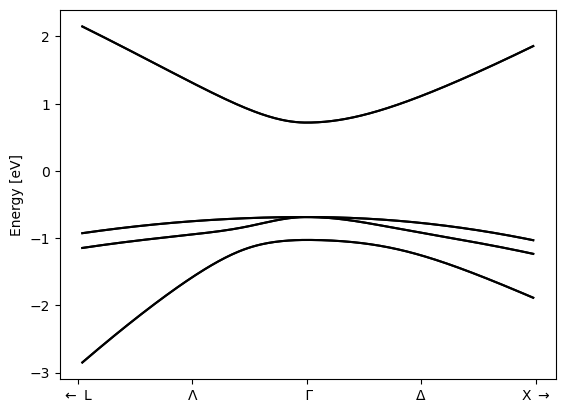

In [99]:
KPpack.PlotBands(Etot,Ktot);

# Plot DOS

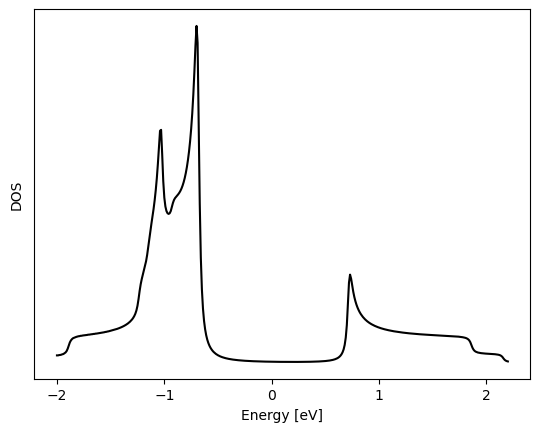

In [100]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [102]:
structure=["AlGaAs_0.8" "15";
    "AlGaAs_0.3" "5";
    "GaAs" "5";
    "AlGaAs_0.3" "5";
    "AlGaAs_0.8" "15";]

#structure=["AlGaAs_0.2" "10";
#    "GaAs" "3";
#    "AlGaAs_0.2" "10";]

Npts,layer,nlayer=KPpack.setStructure(structure,0.24,Temp)

X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp,opt);
Npts

39

# Plot structure

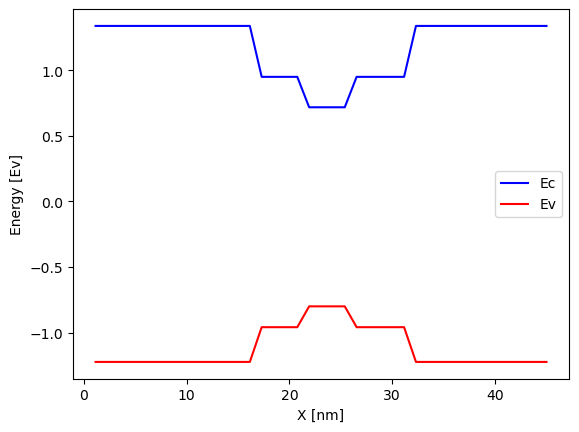

In [104]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

  1.341472 seconds (1.02 M allocations: 69.883 MiB, 79.57% compilation time)


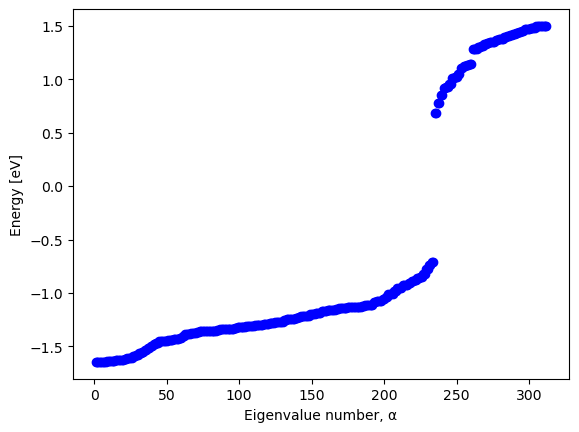

In [105]:
c=0.038; cps=sqrt(c); dx=X[2]-X[1];  cr=0.9; s=0.6; pb=false; siz=size(H0)[1]

@time Eqw0, EVqw0=KPpack.EigSolQW(mlayer,Npts,H0,H1l,H1r,H2,c,cps,dx,Emomentum,pb,cr,s);
KPpack.PloteigvQW(Npts,Eqw0,siz);


# QW Band Structure Calculation

In [106]:
kmax= 1.2; Nt=100;
nc=1; nv=8

sV,sC,pos=KPpack.eigenValQW(real(Eqw0),siz)
#sV=-0.6; sC=-0.1
pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,H0,H1l,H1r,H2,nc,nv,c,cps,sV,sC,Emomentum,pb,cr,s);

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax+0.1,Nt,dx,pl,pm,Npts,H0,H1l,H1r,H2,nc,nv,c,cps,sV,sC,Emomentum,pb,cr,s);

  5.732821 seconds (5.16 M allocations: 935.173 MiB, 5.27% gc time)
  5.401444 seconds (5.13 M allocations: 890.598 MiB, 4.34% gc time)


## Valence Band 

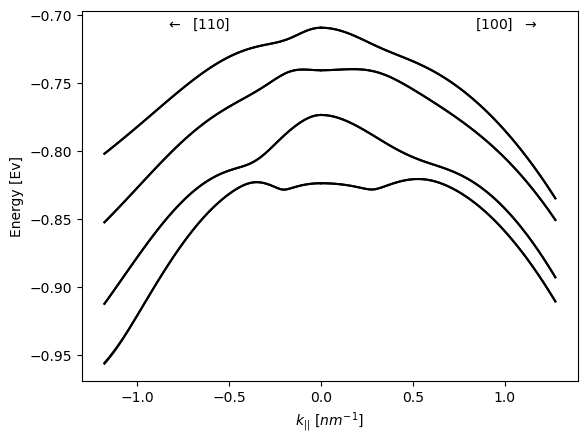

In [107]:
option="complete_V"; poslab=sV
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

## Conduction Band

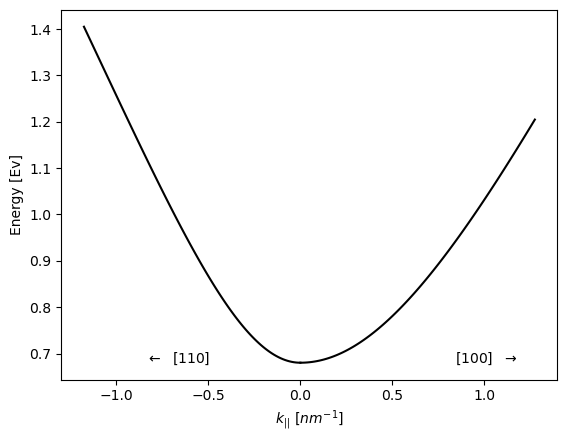

In [108]:
option="complete_C"; poslab=sC
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

# DOS QW

## DOS Valence Band

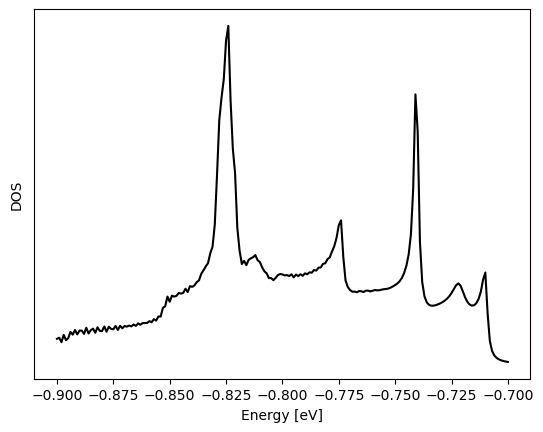

In [111]:
Evqw= vcat(Evq11,Evq10);
EDOSv, aDOSv = KPpack.DOS(-0.9,-0.7,0.001,Evqw,2e-3);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

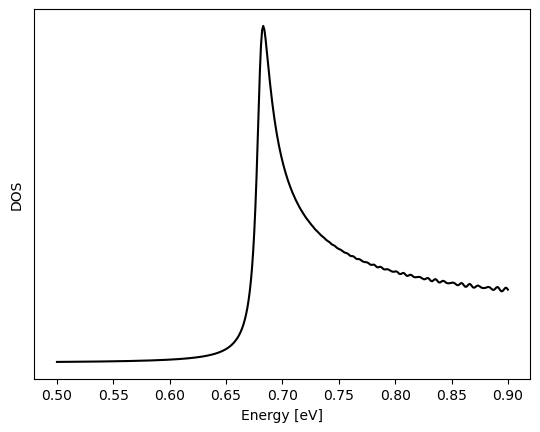

In [112]:
Evqw= vcat(Ecq11,Ecq10);
EDOSc, aDOSc = KPpack.DOS(0.5,0.9,0.001,Evqw,1e-2);
KPpack.PlotDOS(EDOSc,aDOSc);

In [113]:
kx,ky=0.0,0.0
hns=KPpack.FDHamiltonian(H0,H1l,H1r,H2,mlayer,kx,ky,dx,c,cps,Npts,Emomentum,pb,cr,s)

312×312 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 1692 stored entries:
⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢵⢗⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢵⢗⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢵⢗⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢵⢗⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿

In [114]:
hns-hns'

312×312 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 0 stored entries:
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

## =====================================================|

In [115]:
boundPoints

4-element Vector{Float64}:
 14.0
 18.0
 22.0
 27.0

In [116]:
Npts

39

In [117]:
i=21
kx,ky=0.0,0.0

H0Re,H0Im=KPpack.createFuncFD(H0,Emomentum); H1rRe,H1rIm=KPpack.createFuncFD(H1r,Emomentum); H1lRe,H1lIm=KPpack.createFuncFD(H1l,Emomentum)
H2Re,H2Im=KPpack.createFuncFD(H2,Emomentum);
    
H2n=KPpack.evalFuncFD(H2Re,H2Im,mlayer,i,kx,ky,c,cps,cr,s,siz)

mA=KPpack.createFDAmatrix(mlayer,i,H0Re,H0Im,H2Re,H2Im,kx,ky,dx,c,cps,cr,s,siz); 
mB=KPpack.createFDBmatrix(mlayer,i+1,H1rRe,H1rIm,H1lRe,H1lIm,H2Re,H2Im,kx,ky,dx,c,cps,cr,s,siz);
mC=KPpack.createFDCmatrix(mlayer,i-1,H1rRe,H1rIm,H1lRe,H1lIm,H2Re,H2Im,kx,ky,dx,c,cps,cr,s,siz);
mlayer[i].material

"GaAs"

In [118]:
size(mA)[1]

8

In [119]:
EigH2=eigvals(H2n)

8-element Vector{Float64}:
 0.0018848617050636156
 0.0018848617050636156
 0.038416273954419225
 0.038416273954419225
 0.10868000000000001
 0.10868000000000001
 0.10868000000000001
 0.10868000000000001

In [120]:
eigneg=0; eigpos=0

for i in 1:length(EigH2)
    if EigH2[i] <= 0
        eigneg += EigH2[i]
    else
        eigpos += EigH2[i]
    end
end

abs(eigneg/eigpos)

0.0

save a file with band structure

In [121]:
# save a file in folder data with a name given by the user
dat=hcat(Ktot,Etot);
name="BandStructure_GaAs_1"
KPpack.writefile(dat,name)

# Symbolic

## create a Finite differences matrices

# =======================================================

In [122]:
i=20; s=0.6
kx,ky=0.0,0.0
cps=0.38
H1Re,H1Im=KPpack.createFuncFD(H1,Emomentum);

H1n=KPpack.evalFuncFD(H1Re,H1Im,mlayer,i,kx,ky,c,cps,cr,s,siz)
H1n

8×8 Matrix{ComplexF64}:
    0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im    0.0+0.0im
    0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im    0.0+0.0im
    0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im    0.0+0.0im
 -1.824+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im    0.0+0.0im
    0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  1.824+0.0im
    0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im    0.0+0.0im
    0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im    0.0+0.0im
    0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im    0.0+0.0im

In [123]:
H1rRe,H1rIm=KPpack.createFuncFD(H1r,Emomentum); H1lRe,H1lIm=KPpack.createFuncFD(H1l,Emomentum);

H1rn=KPpack.evalFuncFD(H1rRe,H1rIm,mlayer,i,kx,ky,c,cps,cr,s,siz); H1ln=KPpack.evalFuncFD(H1lRe,H1lIm,mlayer,i,kx,ky,c,cps,cr,s,siz)
H1ln

8×8 Matrix{ComplexF64}:
     0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im     0.0+0.0im
     0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im     0.0+0.0im
     0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im     0.0+0.0im
 -0.7296+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im     0.0+0.0im
     0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  1.0944+0.0im
     0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im     0.0+0.0im
     0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im     0.0+0.0im
     0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im     0.0+0.0im

# ================================

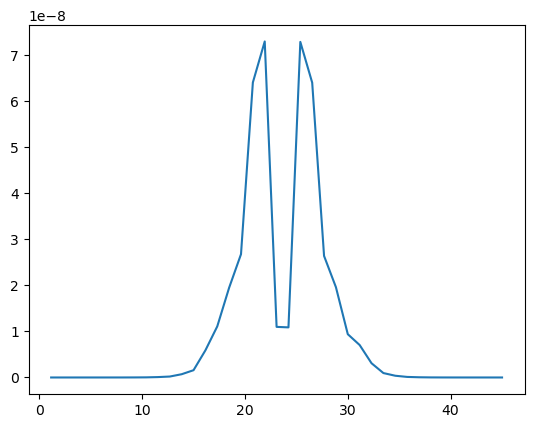

-0.7409177590451909

In [124]:
i=pos-2


Evec=EVqw0[1:siz:end,i]

#vv=Evec.*transpose(Evec')
vv=abs.(Evec)
#vv=Evec
#lt.xlim(150,250)
plt.plot(X,real(vv))
Eqw0[i]

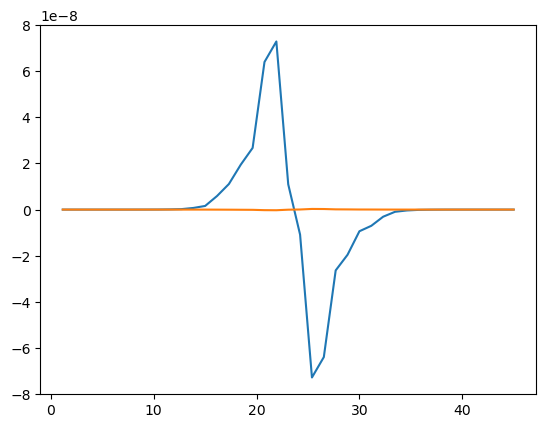

In [125]:
plt.plot(X,real(Evec))
plt.plot(X,imag(Evec));

In [126]:
boundPoints

4-element Vector{Float64}:
 14.0
 18.0
 22.0
 27.0

In [127]:
 i=2

((1-sqrt(3))/2)*mlayer[i].g1 < mlayer[i].g2 && mlayer[i].g2<((1+sqrt(3))/2)*mlayer[i].g1

true

In [128]:
((4*(2*mlayer[i].g2^2-2*mlayer[i].g1*mlayer[i].g2-mlayer[i].g1^2)*cps)/(mlayer[i].delta*(2*mlayer[i].g2+mlayer[i].g1)))

-21.094735414351106

In [129]:
w=0.8
Lm=(mlayer[i].g1+4*mlayer[i].g2-(w*mlayer[i].Ep/mlayer[i].Eg)); L=mlayer[i].g1+4*mlayer[i].g2
M=mlayer[i].g1-2*mlayer[i].g2
Nm=(6*mlayer[i].g3-(w*mlayer[i].Ep/mlayer[i].Eg)); N=6*mlayer[i].g3

10.331999999999999

In [130]:
-Nm

-3.626084671249668